In [1]:
import numpy as np 
from pyxtools.plugnplay import unet, data_sim
import torch
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f'{device} is used')

cpu is used


In [3]:
import importlib
importlib.reload(data_sim)

<module 'pyxtools.plugnplay.data_sim' from '/home/mohahmed/Analysis_P11/pyxtools/plugnplay/data_sim.py'>

In [4]:
x_noisy, x_clean = data_sim.get_data(batch_size=64, img_size=64)


In [5]:
x_noisy.shape

torch.Size([64, 1, 64, 64])

In [6]:
import pyxtools.data_loader.plotting as pxp
%matplotlib

pxp.two_lists_one_slider(x_noisy[:,0,:,:], x_clean[:,0,:,:])

Using matplotlib backend: <object object at 0x1538015ae930>


interactive(children=(IntSlider(value=0, description='Image', max=63), Output()), _dom_classes=('widget-intera…

In [7]:
def train_step(model, get_data, loss_fn, device, batch_size=5, valid_size = .05, img_size = 64):
    
    opt.zero_grad() # zero out gradients from previous step

    x_recon, x = get_data(batch_size, img_size=img_size) # get data
    x_recon.to(device)
    x.to(device)
    
    num_train = len(x_recon)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_indcs, valid_indcs = indices[split:], indices[:split]
    
    x_recon_train = x_recon[train_indcs].to(device)
    x_recon_valid = x_recon[valid_indcs].to(device)
    x_ground_train = x[train_indcs].to(device)
    x_ground_valid = x[valid_indcs].to(device)

    x_model = model(x_recon_train) # predict the cleaned data
    loss = loss_fct(x_model, x_ground_train) # compute the loss
    loss.backward() # compute the gradients
    opt.step() # make a step of the optimizer
    scheduler.step(loss) # make a scheduler step
    
    loss1 = loss.item()
        
    with torch.no_grad():
        x_valid = model(x_recon_valid)
        loss_val = loss_fct(x_valid, x_ground_valid)

    loss2 = loss_val.item()

    print(30*'-')
    print('Iteration: ' + str(num_it))
    print('Current Loss:' + str(loss1))
    for param_group in opt.param_groups:
        print('Current lr:' + str(param_group['lr']))
    return loss1, loss2 

In [30]:
import torch.nn as nn

denoiser = unet.UNet().to(device)
train_loss = []
valid_loss = []

In [31]:
valid_size = .05 # 5 percent
batch_size = 512

In [32]:
max_it = 200
opt = torch.optim.Adam(denoiser.parameters(), lr=5e-4)
loss_fct = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=9)

for num_it in range(max_it):
    loss1, loss2 = train_step(denoiser, data_sim.get_data, loss_fct, device=device, batch_size=batch_size)
    train_loss.append(loss1)
    valid_loss.append(loss2)

------------------------------
Iteration: 0
Current Loss:0.061467815190553665
Current lr:0.0005
------------------------------
Iteration: 1
Current Loss:0.04896987974643707
Current lr:0.0005
------------------------------
Iteration: 2
Current Loss:0.03661084547638893
Current lr:0.0005
------------------------------
Iteration: 3
Current Loss:0.027570059522986412
Current lr:0.0005
------------------------------
Iteration: 4
Current Loss:0.013641712255775928
Current lr:0.0005
------------------------------
Iteration: 5
Current Loss:0.006069679744541645
Current lr:0.0005
------------------------------
Iteration: 6
Current Loss:0.00338656734675169
Current lr:0.0005
------------------------------
Iteration: 7
Current Loss:0.005005166865885258
Current lr:0.0005
------------------------------
Iteration: 8
Current Loss:0.0035260424483567476
Current lr:0.0005
------------------------------
Iteration: 9
Current Loss:0.004770847037434578
Current lr:0.0005
------------------------------
Iteration: 

In [ ]:
loss_fct(x_clean, x_noisy)

In [33]:
x_pred = denoiser(x_noisy)

In [34]:
loss_fct(x_clean, x_pred)

tensor(0.0014, grad_fn=<MseLossBackward0>)

In [35]:
%matplotlib ipympl

interactive(children=(IntSlider(value=0, description='Image', max=63), Output()), _dom_classes=('widget-intera…

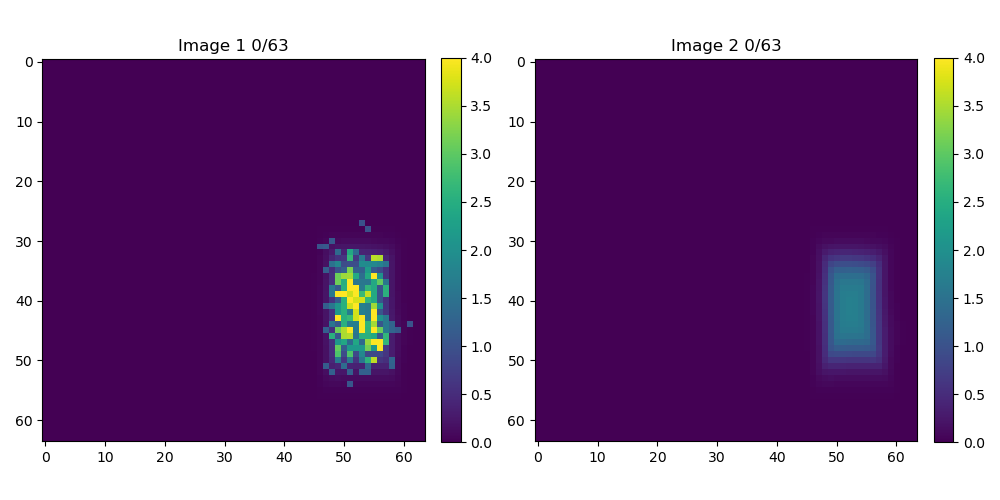

In [36]:
pxp.two_lists_one_slider(x_noisy[:,0,...].detach().numpy(), x_clean[:,0,...].detach().numpy(), vmax2 = 4, vmax1=4)

interactive(children=(IntSlider(value=0, description='Image', max=63), Output()), _dom_classes=('widget-intera…

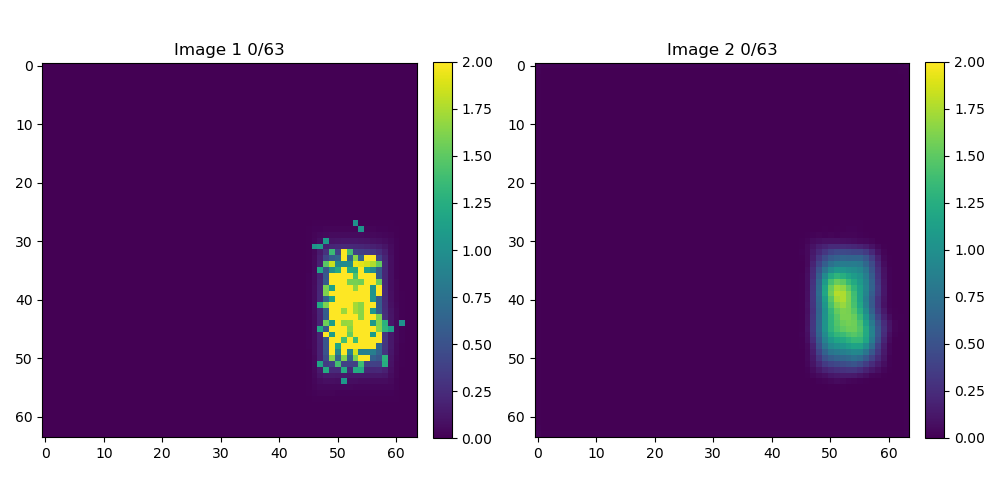

In [38]:
pxp.two_lists_one_slider(x_noisy[:,0,...].detach().numpy(), x_pred[:,0,...].detach().numpy(), vmax1 = 2, vmax2 = 2)

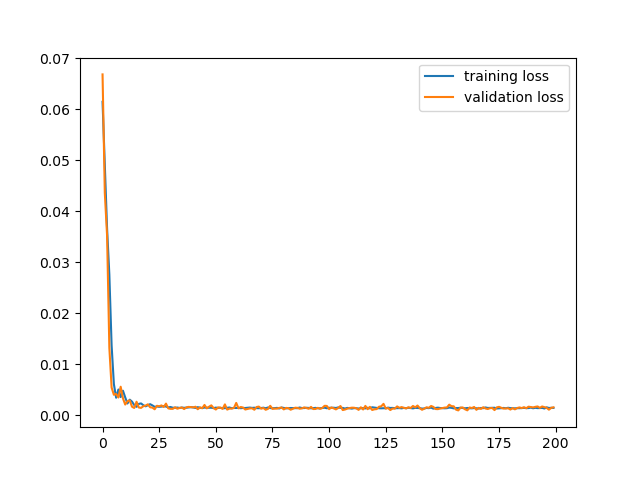

In [39]:
plt.figure()
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()